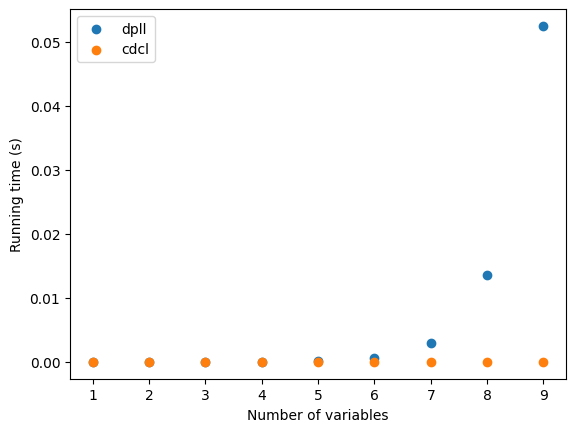

In [54]:
import random
import timeit
from matplotlib import pyplot as plt
from pysat.solvers import Solver

def generate_test_case(num_vars, num_clauses, clause_length):
    test_case = []
    for _ in range(num_clauses):
        clause = set()
        while len(clause) < clause_length:
            var = random.randint(1, num_vars)
            negated = random.choice([True, False])
            clause.add(-var if negated else var)
        test_case.append(list(clause))
    return test_case



# If the formula is empty, it is trivially satisfiable, and the current assignment is returned.
# If any clause in the formula is empty, the formula is unsatisfiable, and the current assignment is returned.
# If there exists a unit clause (a clause with only one literal), the literal in that clause must be assigned a truth value. The clause containing that literal and any other clauses containing the negation of that literal are removed from the formula. The DPLL algorithm is then called recursively on the simplified formula with the new assignment.
# If there is no unit clause, a variable is selected (the first literal of the first clause is arbitrarily chosen in this implementation), and the DPLL algorithm is called recursively twice: once with the variable assigned True, and once with the variable assigned False. If either recursive call returns a satisfiable assignment, that assignment is returned.
# If no satisfying assignment is found, the function returns False along with the current assignment.
dpll_run_count = 0
def dpll(formula, partial_assignment):
    global dpll_run_count
    dpll_run_count += 1
    if not formula:
        return True, partial_assignment
    
    if any(not clause for clause in formula):
        return False, partial_assignment
    
    unit_clauses = [clause for clause in formula if len(clause) == 1]
    if unit_clauses:
        unit_literal = unit_clauses[0][0]
        new_formula = [[literal for literal in clause if literal != -unit_literal] for clause in formula if unit_literal not in clause]
        return dpll(new_formula, partial_assignment + [unit_literal])
    
    variable = abs(formula[0][0])
    
    for value in [variable, -variable]:
        new_formula = [[literal for literal in clause if literal != -value] for clause in formula if value not in clause]
        result, new_assignment = dpll(new_formula, partial_assignment + [value])
        if result:
            return result, new_assignment

    return False, partial_assignment


# Instantiate the CDCL solver (Glucose3 in this case)

data = []
for i in range(1, 10):
    solver = Solver(name ="g3",bootstrap_with=None, use_timer=True)
    num_vars = i
    num_clauses = 2**(i-1) * 2**(i-1)
    clause_length = i
    test_case = generate_test_case(num_vars, num_clauses, clause_length)
    
    for clause in test_case:
        solver.add_clause(clause)


    dpll_time = timeit.timeit(lambda: dpll(test_case, []), number=1)
    time = timeit.timeit(lambda: solver.solve(), number = 1)
    
    data.append((num_vars, num_clauses, clause_length, dpll_time,time))
    solver.delete()

plt.scatter([d[0] for d in data], [d[3] for d in data], label='dpll')
plt.scatter([d[0] for d in data], [d[4] for d in data], label='cdcl')
plt.xlabel('Number of variables')
plt.ylabel('Running time (s)')
plt.legend()
plt.show()